In [83]:
%load_ext autoreload
%autoreload 2
import music_metrics as mm
from glob import glob
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from rdkit.Chem import Crippen
from rdkit.Chem import AllChem as Chem
from rdkit.Chem import PandasTools
from rdkit import SimDivFilters,DataStructs
import random
import time
from collections import OrderedDict
from awesome_utils import *

%matplotlib inline
awesome_settings()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Load one run

In [84]:
glob('data/*.csv')


['data/music80_00_melodicity_results.csv',
 'data/music80_00_ratio-of-steps_results.csv',
 'data/music80_00_tonality_results.csv',
 'data/music80_02_melodicity_results.csv',
 'data/music80_02_ratio-of-steps_results.csv',
 'data/music80_02_tonality_results.csv',
 'data/music80_04_melodicity_results.csv',
 'data/music80_04_ratio-of-steps_results.csv',
 'data/music80_04_tonality_results.csv',
 'data/music80_06_melodicity_results.csv',
 'data/music80_06_ratio-of-steps_results.csv',
 'data/music80_06_tonality_results.csv',
 'data/music80_08_melodicity_results.csv',
 'data/music80_08_ratio-of-steps_results.csv',
 'data/music80_08_tonality_results.csv',
 'data/music80_10_melodicity_results.csv',
 'data/music80_10_ratio-of-steps_results.csv',
 'data/music80_10_tonality_results.csv']

In [85]:
datasets={'music80':'music80.csv' }

def g_accuracy(row):
    n = row['n_samples']
    n_good =  row['uniq_samples']
    return n_good/float(n)*100

def d_accuracy(row):
    return np.mean([row[i] for i in row.index if 'Accuracy_' in i])*100

def split_expname(a):
    pieces = a.split('_')
    return pieces[0],float(pieces[1])*0.1,pieces[2]

In [86]:
csv_file='data/music80_08_tonality_results.csv'
df = pd.read_csv(csv_file)
print(df.columns)
df['g_accuracy']=df.apply(g_accuracy,axis=1)
df['d_accuracy']=df.apply(d_accuracy,axis=1)
exp_name = df.iloc[0].exp_name
data,tau,obj = split_expname(exp_name)
print(df.shape)
df.head()

Index([u'exp_name', u'Batch', u'test_loss', u'mean_length', u'n_samples', u'uniq_samples', u'ratio_of_steps', u'melodicity', u'tonality', u'model_samples', u'neg-loglike', u'D_loss_0', u'Accuracy_0', u'D_loss_1', u'Accuracy_1', u'D_loss_2', u'Accuracy_2', u'D_loss_3', u'Accuracy_3'], dtype='object')
(200, 21)


,exp_name,Batch,test_loss,mean_length,n_samples,uniq_samples,ratio_of_steps,melodicity,tonality,model_samples,...,D_loss_0,Accuracy_0,D_loss_1,Accuracy_1,D_loss_2,Accuracy_2,D_loss_3,Accuracy_3,g_accuracy,d_accuracy
0,music80_08_tonality,0,8.436623,108.986625,32000,31428,0.282511,0.098477,0.052252,music80_08_tonality_0,...,0.626940,1.0,0.603844,1.0,0.578080,1.0,0.547630,1.0,98.212500,100.0
1,music80_08_tonality,1,8.356718,116.379688,6400,6325,0.282952,0.099095,0.052836,music80_08_tonality_1,...,0.523235,1.0,0.501125,1.0,0.474130,1.0,0.486829,1.0,98.828125,100.0
2,music80_08_tonality,2,8.294280,122.016875,6400,6337,0.276796,0.097829,0.052080,music80_08_tonality_2,...,0.430359,1.0,0.406247,1.0,0.384702,1.0,0.375503,1.0,99.015625,100.0
3,music80_08_tonality,3,8.285603,124.015156,6400,6334,0.277164,0.100248,0.054173,music80_08_tonality_3,...,0.348008,1.0,0.328523,1.0,0.309246,1.0,0.292388,1.0,98.968750,100.0
4,music80_08_tonality,4,8.284185,124.468750,6400,6332,0.273844,0.101169,0.054079,music80_08_tonality_4,...,0.283704,1.0,0.258367,1.0,0.244647,1.0,0.227649,1.0,98.937500,100.0


## accuracy

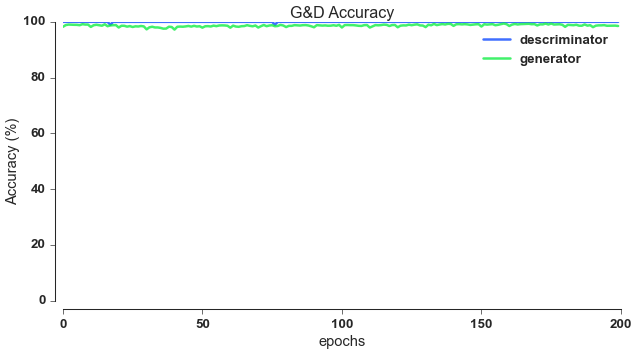

In [87]:
epochs = df['Batch']
plt.plot(epochs,df['d_accuracy'],lw=3,alpha=0.75,label='descriminator')
plt.plot(epochs,df['g_accuracy'],lw=3,alpha=0.75,label='generator')
plt.title('G&D Accuracy')
plt.xlabel('epochs')
plt.ylabel('Accuracy (%)')
plt.ylim([0,100])
sns.despine(offset=10)
plt.legend(loc='best')
save_result('{}_accuracy'.format(exp_name))
plt.show()

## metrics

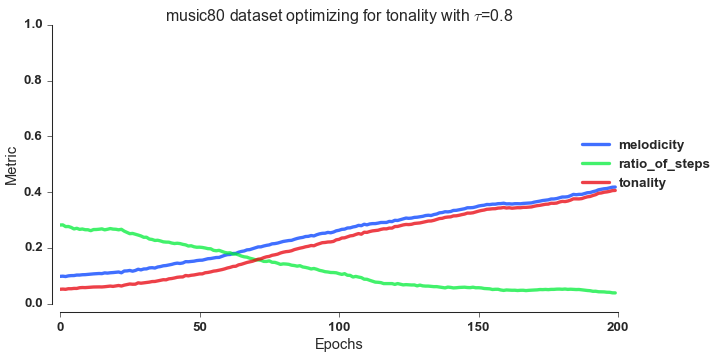

In [88]:
for i in ['melodicity', 'ratio_of_steps', 'tonality']:
    plt.plot(epochs,df[i],lw=4,alpha=0.75,label=i)

plt.title('{} dataset optimizing for {} with $\\tau$={}'.format(data,obj,tau))
plt.ylabel('Metric')
plt.xlabel('Epochs')
plt.ylim([0,1])
sns.despine(offset=10)
plt.legend(bbox_to_anchor=[1.05, 0.5], loc='center')
save_result('{}_metrics'.format(exp_name))
plt.show()

## summary results

In [89]:
def summarize(df,metrics,avg_last=10):
    avg_last =10
    sub_df = df.iloc[-avg_last:]
    data,tau,obj = split_expname(sub_df.iloc[0].exp_name)
    result = sub_df[metrics].mean().to_dict()
    result.update({'data':data,'tau':tau,'objective':obj})
    return result

metrics=['g_accuracy','d_accuracy','ratio_of_steps',
         'tonality', 'melodicity']

result = summarize(df,metrics,avg_last=10)
result

{'d_accuracy': 100.0,
 'data': 'music80',
 'g_accuracy': 98.599999999999994,
 'melodicity': 0.41027246764318248,
 'objective': 'tonality',
 'ratio_of_steps': 0.042760438152424543,
 'tau': 0.8,
 'tonality': 0.39746118994016932}

In [93]:
data_df = pd.read_csv('../odyssey/data/{}'.format(datasets[data]))['song']
data_df = data_df.sample(n=min(len(data_df),6400)).dropna()
smiles = data_df.values
reward = mm.load_reward(obj)
print exp_name

music80_08_tonality


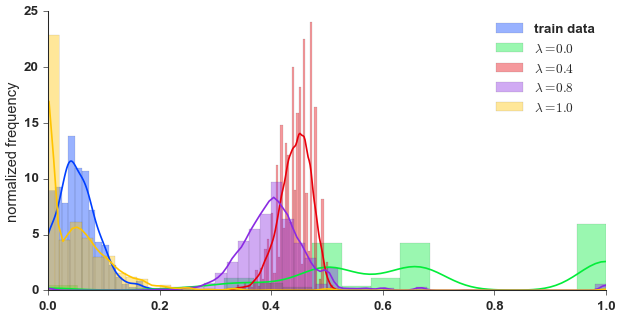

In [107]:
data_df = pd.read_csv('../odyssey/data/{}'.format(datasets[data]))['song']
data_df = data_df.sample(n=min(len(data_df),6400)).dropna()
smiles = data_df.values
reward = mm.load_reward(obj)
sns.distplot(reward(smiles),label='train data')

dataset = 'music80'
metric = 'tonality'
for lamb in ['00', '04', '08', '10']:
    lambf = float(lamb) / 10
    exp = '{}_{}_{}'.format(dataset, lamb, metric)
    smi_file = os.path.join('data',exp, 'epoch_data', exp +'_199.abc')
    comp = mm.read_smi(smi_file)
    comp = [s for s in comp if mm.verify_sequence(s)]
    sns.distplot(reward(comp),label='$\\lambda={:.1f}$'.format(lambf))

plt.ylabel('normalized frequency')
plt.legend(loc='best')
sns.despine()
plt.xlim([0,1])
plt.show()

# iterate over all

In [26]:
result_rows=[]
for csv_file  in glob('data/*.csv'):
    df = pd.read_csv(csv_file)
    df['g_accuracy']=df.apply(g_accuracy,axis=1)
    df['d_accuracy']=df.apply(d_accuracy,axis=1)
    result = summarize(df,metrics,avg_last=10)
    result_rows.append(result)
df = pd.DataFrame(result_rows)
print(df.shape)
df.head()

(18, 8)


,d_accuracy,data,g_accuracy,melodicity,objective,ratio_of_steps,tau,tonality
0,0.0,music80,72.321562,0.519558,melodicity,0.062453,0.0,0.459625
1,0.0,music80,99.776562,0.003700,ratio-of-steps,0.894053,0.0,0.001191
2,0.0,music80,59.430312,0.614485,tonality,0.025238,0.0,0.604917
3,100.0,music80,74.782187,0.562985,melodicity,0.042826,0.2,0.381083
4,100.0,music80,99.755313,0.018802,ratio-of-steps,0.815613,0.2,0.004784


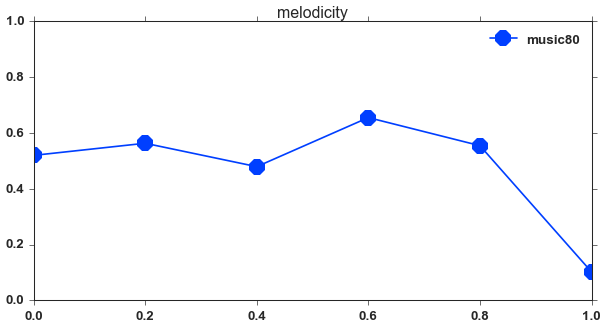

KeyError: 'ratio-of-steps'

In [28]:
for obj,grp1 in df.groupby(by='objective'):
    for data,grp2 in grp1.groupby(by='data'):
        sub_df = grp2.sort_values(by='tau')
        plt.plot(sub_df['tau'],sub_df[obj],'-8', markersize=20,label=data)
    plt.legend(loc='best')
    plt.xlim([0,1])
    plt.ylim([0,1])
    plt.title(obj)
    plt.show()